# 鸢尾花数据集分类-XGBoost

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
data = load_iris()

In [35]:
X = data.data
y = data.target

In [36]:
X_train, X_test, y_trian, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [37]:
model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
model.fit(X_train,y_trian)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
preds = model.predict(X_test)
acc = accuracy_score(y_test,preds)

In [49]:
cm = confusion_matrix(y_test,preds)

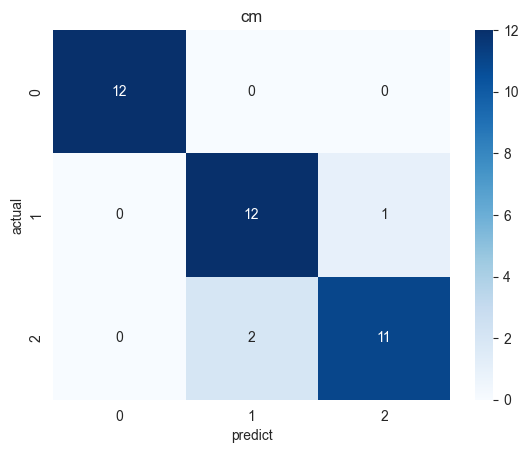

In [46]:
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel("predict")
plt.ylabel("actual")
plt.title('cm')
plt.show()

In [50]:
print(acc)

0.9210526315789473


# 含早停、超参数调优、特征重要性的xgboost实战

In [1]:
!pip install optuna


   ---------- ----------------------------- 1/4 [colorlog]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ---------------------------------------- 4/4 [optuna]




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
X,y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=1,
    random_state=42
)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X=pd.DataFrame(X,columns=feature_names)

In [16]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,test_size=0.25,random_state=42)

In [17]:
# 定义早停训练函数
def train_xgb(params,X_train,y_train,X_val,y_val,early_stopping_rounds=30):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dval = xgb.DMatrix(X_val,label=y_val)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain,'train'),(dval,'val')],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )
    return model

In [18]:
# 使用 Optuna 进行超参数调优
def objective(trial):
    params = {
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'booster':'gbtree',
        'random_state':42,
        'eta':trial.suggest_float('eta',0.01,0.3),
        'max_depth':trial.suggest_int('max_depth',3,10),
        'subsample':trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0.5,1.0),
        'gamma':trial.suggest_float('gamma',0,5),
        'min_child_weight':trial.suggest_int('min_child_weight',1,10),
        'reg_alpha':trial.suggest_float('reg_alpha',0,10),
        'reg_lambda':trial.suggest_float('reg_lambda',0,10),
        'tree_method':'hist'
    }
    model = train_xgb(params,X_train,y_train,X_val,y_val,early_stopping_rounds=30)
    best_iter = model.best_iteration
    val_pred=model.predict(xgb.DMatrix(X_val))
    val_pred_binary = [1 if pred>0.5 else 0 for pred in val_pred]
    accuracy = accuracy_score(y_val,val_pred_binary)
    return -accuracy

In [19]:
print('贝叶斯调优开始')
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=50)

print('贝叶斯调优结束')

[I 2025-12-06 13:43:14,369] A new study created in memory with name: no-name-e5cfccfb-e6b2-4351-9388-27fde1c34afe


贝叶斯调优开始


[I 2025-12-06 13:43:14,857] Trial 0 finished with value: -0.91 and parameters: {'eta': 0.04386243787975574, 'max_depth': 7, 'subsample': 0.6316424528728743, 'colsample_bytree': 0.8189647377282148, 'gamma': 4.9740880499285876, 'min_child_weight': 3, 'reg_alpha': 9.052971707609856, 'reg_lambda': 6.7183833484198185}. Best is trial 0 with value: -0.91.
[I 2025-12-06 13:43:14,963] Trial 1 finished with value: -0.96 and parameters: {'eta': 0.25780127215536564, 'max_depth': 5, 'subsample': 0.7859547821060628, 'colsample_bytree': 0.6431544151922857, 'gamma': 1.0395153857634154, 'min_child_weight': 8, 'reg_alpha': 0.4748558212157228, 'reg_lambda': 7.054817154944369}. Best is trial 1 with value: -0.96.
[I 2025-12-06 13:43:15,073] Trial 2 finished with value: -0.945 and parameters: {'eta': 0.13228338761049227, 'max_depth': 3, 'subsample': 0.9078552146568618, 'colsample_bytree': 0.5093913453865605, 'gamma': 4.278991928133488, 'min_child_weight': 9, 'reg_alpha': 2.1119371488790586, 'reg_lambda': 1.

贝叶斯调优结束


In [20]:
print('最优参数：',study.best_params)

最优参数： {'eta': 0.2954493202843215, 'max_depth': 6, 'subsample': 0.5585607433752771, 'colsample_bytree': 0.50161213210818, 'gamma': 2.468411425882575, 'min_child_weight': 3, 'reg_alpha': 0.19538098958787387, 'reg_lambda': 9.561140880379442}


In [21]:
print('用最优参数训练模型')
best_params = study.best_params
best_params['objective']='binary:logistic'
best_params['eval_metric']='logloss'
best_params['random_state']=42
best_params['tree_method']='hist'
final_model = train_xgb(best_params,X_train_val,y_train_val,X_test,y_test,early_stopping_rounds=30)

用最优参数训练模型


In [23]:
# 在测试集上评估
dtest = xgb.DMatrix(X_test,label=y_test)
y_pred_proba = final_model.predict(dtest)
y_pred = [1 if pred>0.5 else 0 for pred in y_pred_proba]

In [24]:
test_acc = accuracy_score(y_test, y_pred)
print(f"测试集准确率: {test_acc:.4f}")
print("分类报告:")
print(classification_report(y_test, y_pred))

测试集准确率: 0.9500
分类报告:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       100
           1       0.94      0.96      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



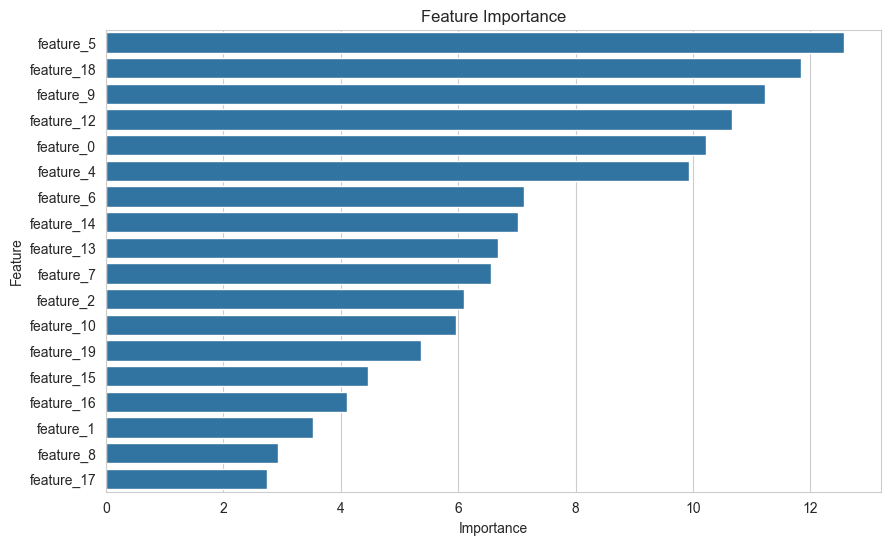

In [25]:
# 特征重要性可视化
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()